# Airbnb data analysis and price prediction

Final project for Data Science bootcamp organized by Sages (Kodołamacz).

### Table of contents
1. Abstract
2. Dataset
3. Libraries to download
4. Data exploration, visualisation and preparation for modelling
5. Price prediction
6. Summary

### 1. Abstract

The aim of this project is to analyze choosen dataset and create model for price prediction. Such a tool could be used in smart pricing algorithm for airbnb user. Potentially if you want to offer your apartment in Airbnb service, after entering information about the apartment, algorithm will suggest you what price is the most appropriate. 
In this project different models will be compared to achive best final results.

### 2. Dataset

Dataset is gathered from: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data.

This dataset describes the listing activity and metrics in New York City for 2019. This data file includes information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions. This public dataset is part of Airbnb, and the original source can be found here:http://insideairbnb.com/.

### 3. Libraries to download

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import folium
from folium.plugins import HeatMap
from IPython.display import display

from scipy.spatial import distance
from geopy import distance as distancegeopy

import eli5 #Model interpretation module

### 4. Data exploration, visualisation and preparation for modelling

In [141]:
df = pd.read_csv('./dataset/AB_NYC_2019.csv') #loading data

Let's get overview and basic statistics of our dataset.

In [142]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,nan,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [144]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We can notice that most of null values appear in column reviews_per_month and last_review. As we can see, this column receive null value only if listing don't have any reviews, so we can replace missing data with zeros.

There are also some null values in column name and host_name. However, we won't be using them in modelling, so we want be editting those columns in this project.                                 

In [145]:
df.fillna({'reviews_per_month':0}, inplace = True)
df.fillna({'last_review':0}, inplace = True)

Now let's analyze our features one by one

In [146]:
# Column "id" is unique value for each observation so we will not use it in further analysis
# Column "host_id" and "host_name" refers to specific users and it shouldn't be analyzed.
# Column "name" contains title of each listings and won't be analyzed in this part of the project. (It could be used to find if some specific words used in title are related to price.)
# Column "last_review" contain informations about date of last review so it shouldn't be related to price.
df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True) 

In [147]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,0.10,1,0


- neighbourhood_group

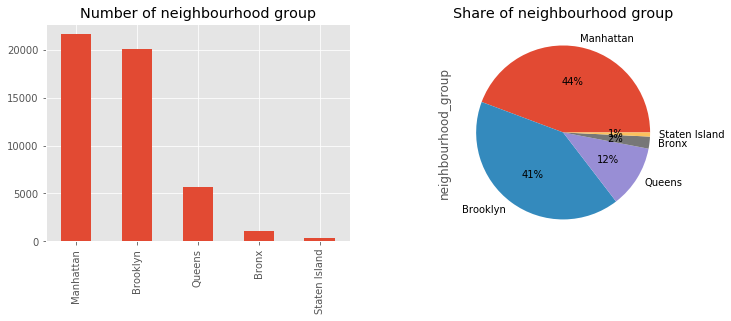

In [148]:
f,ax=plt.subplots(1,2, figsize=(12,4))
df.neighbourhood_group.value_counts().plot(kind='bar', title='Number of neighbourhood group', ax = ax[0])
df.neighbourhood_group.value_counts().plot(kind='pie', title='Share of neighbourhood group', ax = ax[1], autopct='%1.f%%')

As we can expect, most of the listings are located in Manhattan and Brooklyn districts. It is understandable as these two districts are the most attractive for turists. As a result majority of airbnb properties are located in Manhattan and Brooklyn. 

- neighbourhood

In [149]:
df.neighbourhood.value_counts()

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Rossville                1
Willowbrook              1
Fort Wadsworth           1
Woodrow                  1
Richmondtown             1
Name: neighbourhood, Length: 221, dtype: int64

In presented dataset we have 221 different neighbourhood values which is more detailed describtion of location than previous feature. To avoid creating 221 new columns by one hot encoding, we will not use this column in model as location  is covered by other features (longitude, latitude and neighbourhood_group).

In [150]:
df.drop(['neighbourhood'], axis=1, inplace=True)

- latitude and longitude

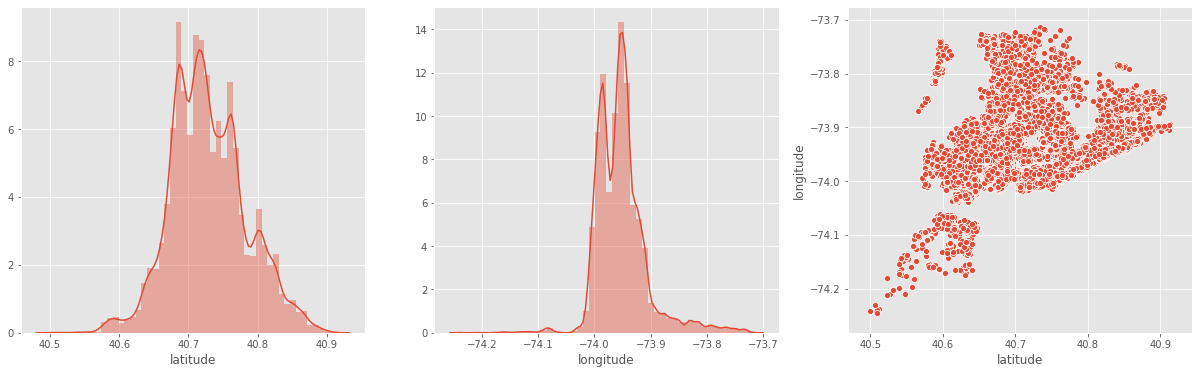

In [151]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(df['latitude'], ax=axes[0])
sns.distplot(df['longitude'], ax=axes[1])
sns.scatterplot(x= df['latitude'], y=df['longitude'])

- room_type

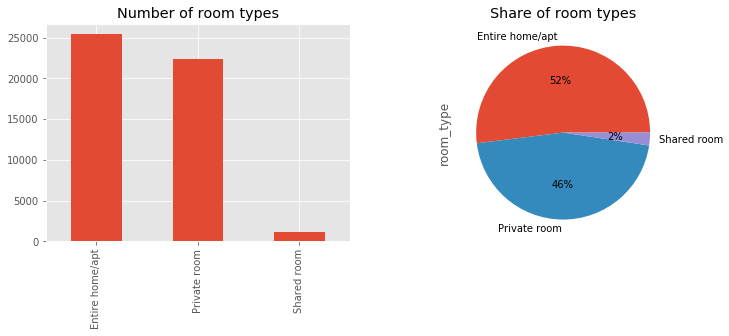

In [152]:
f,ax=plt.subplots(1,2, figsize=(12,4))
df.room_type.value_counts().plot(kind='bar', title='Number of room types', ax=ax[0])
df.room_type.value_counts().plot(kind='pie', title='Share of room types', ax=ax[1], autopct='%1.f%%')


- minimum_nights

In [153]:
df.minimum_nights.value_counts().sort_values(ascending=False).head(5)
# Most of bookings are available for minimum 1, 2 or 3 nights.

1     12720
2     11696
3      7999
30     3760
4      3303
Name: minimum_nights, dtype: int64

In [154]:
df.minimum_nights.sort_values(ascending=False).head(15)
# As we can see there are same observation with minimum nights more than one year which are probably mistake

5767     1250
2854     1000
38664     999
26341     999
13404     999
11193     500
47620     500
8014      500
14285     500
7355      500
10829     480
34487     400
1305      370
15946     366
17338     365
Name: minimum_nights, dtype: int64

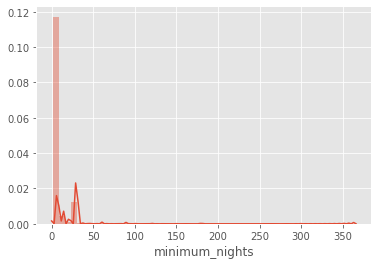

In [155]:
sns.distplot(df['minimum_nights'][df['minimum_nights']<366])

If we look at distribution of minimum_nights we can notice that it is skewed. We will try to improve its distribution by using logarythmic transformation.

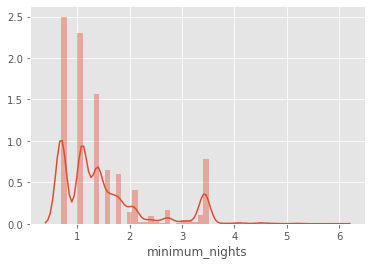

In [156]:
sns.distplot(np.log1p(df['minimum_nights'][df['minimum_nights']<366]))

In [157]:
df['minimum_nights'] = np.log1p(df['minimum_nights'])

- number_of_reviews

In [158]:
df['number_of_reviews'].describe()

count   48895.00
mean       23.27
std        44.55
min         0.00
25%         1.00
50%         5.00
75%        24.00
max       629.00
Name: number_of_reviews, dtype: float64

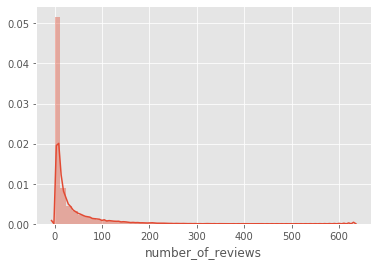

In [159]:
sns.distplot(df['number_of_reviews'])

As in the example above, we can notice highly skewed distribution. Let's try logarythmic transformation to improve distribution. 

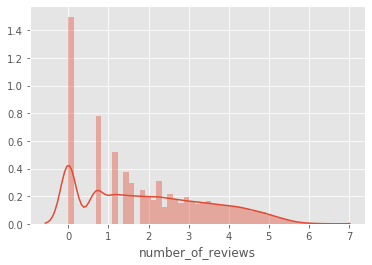

In [160]:
sns.distplot(np.log1p(df['number_of_reviews'])) 

In [161]:
df['number_of_reviews'] = np.log1p(df['number_of_reviews'])

- reviews_per_month

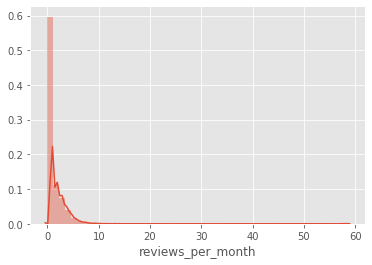

In [162]:
sns.distplot(df['reviews_per_month'])

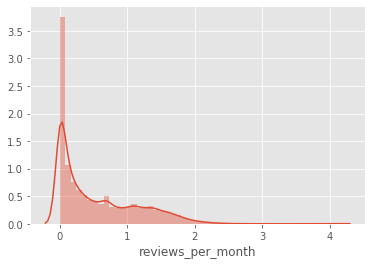

In [163]:
sns.distplot(np.log1p(df['reviews_per_month'])) 

As in the example above. Logarythmic transformation is not perfect, but make data distribution less skewed, so data should be better in modelling.

In [164]:
df['reviews_per_month'] = np.log1p(df['reviews_per_month'])

- calculated_host_listings_count

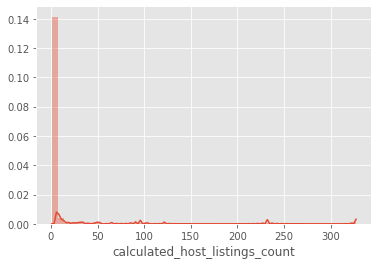

In [165]:
sns.distplot(df['calculated_host_listings_count'])

In [166]:
df['calculated_host_listings_count'].sort_values()

24447      1
27993      1
27995      1
27996      1
27999      1
        ... 
41466    327
41467    327
41468    327
41470    327
41445    327
Name: calculated_host_listings_count, Length: 48895, dtype: int64

In [167]:
df['calculated_host_listings_count'].value_counts().head()

1    32303
2     6658
3     2853
4     1440
5      845
Name: calculated_host_listings_count, dtype: int64

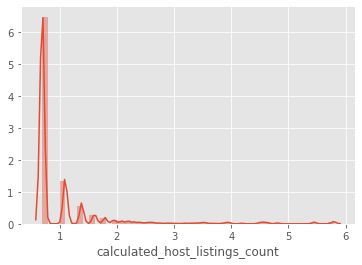

In [168]:
sns.distplot(np.log1p(df['calculated_host_listings_count'])) 

In [169]:
df['calculated_host_listings_count'] = np.log1p(df['calculated_host_listings_count'])

- availability_365

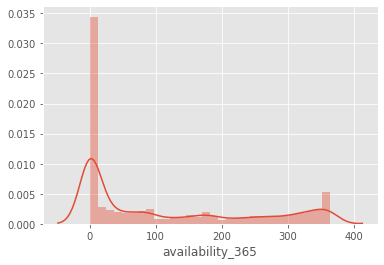

In [170]:
sns.distplot(df['availability_365'])

In [171]:
df['availability_365'].value_counts()

0      17533
365     1295
364      491
1        408
89       361
       ...  
195       26
196       24
183       24
181       23
202       20
Name: availability_365, Length: 366, dtype: int64

One of the most common value are 365 and 364 which are apartments availaible for whole year. On the other side there are 408 listings with availability 1, which probably correspond to long term bookings (apartments for long term rent - min. whole year).  
Over 17k of observations have 0 availability. It could probably be value for those listings were availability was not given.

According to reviews per month and number of reviews we can estimate for how many months listing is availaible on the market. It may have an influance if some bookings are new in the airbnb and others are available for a long time. 

In [172]:
df['exposure_period'] = df['number_of_reviews']/df['reviews_per_month']

In [173]:
df.exposure_period

0       12.08
1       11.89
2         nan
3        3.24
4       24.16
         ... 
48890     nan
48891     nan
48892     nan
48893     nan
48894     nan
Name: exposure_period, Length: 48895, dtype: float64

In [174]:
df.fillna({'exposure_period':0}, inplace = True)
df.exposure_period.value_counts()

0.00     10052
1.00      1558
35.00      909
23.45      695
14.21      423
         ...  
2.87         1
3.66         1
2.31         1
4.74         1
2.29         1
Name: exposure_period, Length: 14716, dtype: int64

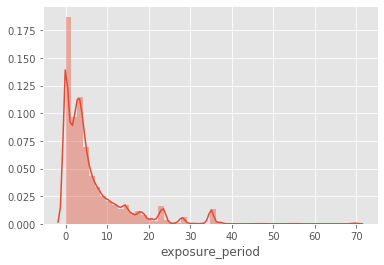

In [175]:
sns.distplot(df['exposure_period'])

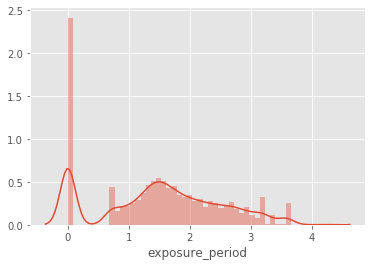

In [176]:
sns.distplot(np.log1p(df['exposure_period'])) 

In [177]:
df['exposure_period'] = np.log1p(df['exposure_period'])

Let's check how our database look like after transformation

In [178]:
df

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,exposure_period
0,Brooklyn,40.65,-73.97,Private room,149,0.69,2.30,0.19,1.95,365,2.57
1,Manhattan,40.75,-73.98,Entire home/apt,225,0.69,3.83,0.32,1.10,355,2.56
2,Manhattan,40.81,-73.94,Private room,150,1.39,0.00,0.00,0.69,365,0.00
3,Brooklyn,40.69,-73.96,Entire home/apt,89,0.69,5.60,1.73,0.69,194,1.44
4,Manhattan,40.80,-73.94,Entire home/apt,80,2.40,2.30,0.10,0.69,0,3.23
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,40.68,-73.95,Private room,70,1.10,0.00,0.00,1.10,9,0.00
48891,Brooklyn,40.70,-73.93,Private room,40,1.61,0.00,0.00,1.10,36,0.00
48892,Manhattan,40.81,-73.95,Entire home/apt,115,2.40,0.00,0.00,0.69,27,0.00
48893,Manhattan,40.76,-73.99,Shared room,55,0.69,0.00,0.00,1.95,2,0.00


#### Data visualisation

We can use violinplot to show density and distribtuion of prices in different neighbours group  

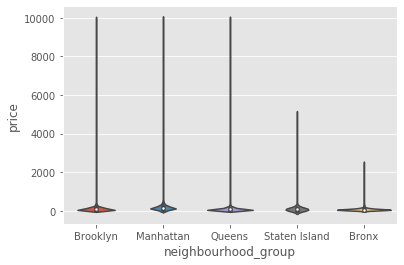

In [179]:
sns.violinplot(data=df, x='neighbourhood_group', y='price')

We can see that there are some listings with very high prices witch outlies from majority of prices. 
To see the distributions we will to remove prices higher than 500

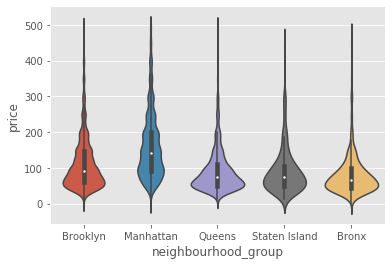

In [180]:
sns.violinplot(data=df[df.price<500], x='neighbourhood_group', y='price')

We can notice that Manhattan have the highest prizes which is not a suprise. It is main turistic and business area. The lowest price are noticable in Staten Island and Bronx.

There are a lot of libriaries to visualise spatial data. One of them is folium. Using this library we can create different types of maps and visualise our data. One of the most common is heatmap which shows density of selected data features.

In [181]:
heatmap=folium.Map([40.7000,-74.0000],zoom_start=10)
HeatMap(df[['latitude','longitude']].dropna(),radius=6,gradient={0.25:'yellow',0.5:'orange',0.75:'red', 1:'brown'}).add_to(heatmap)
heatmap

To chech the correlation between different features we can use correlation matrix

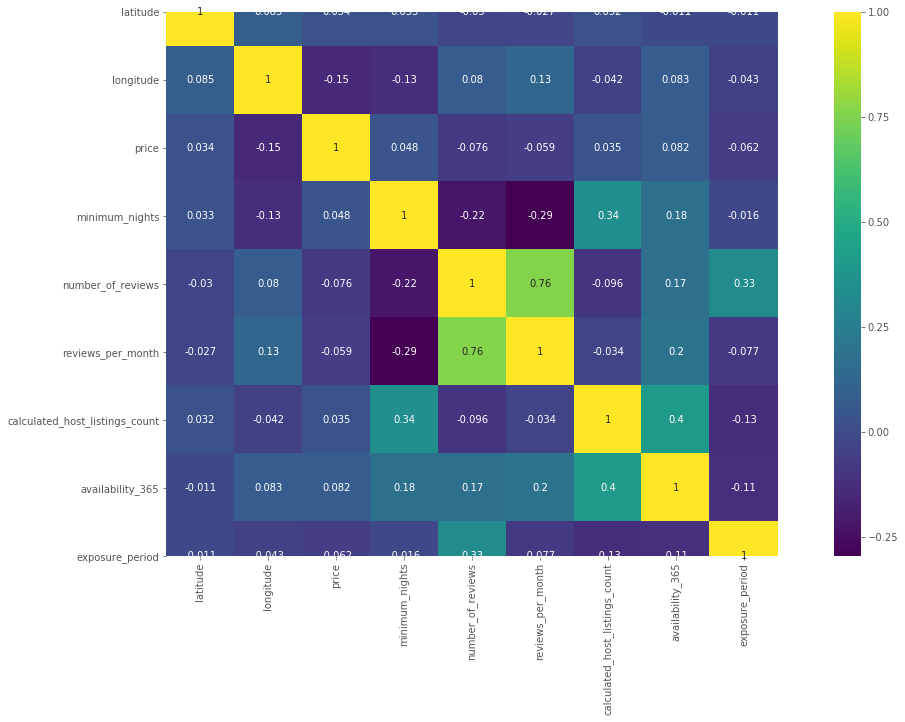

In [182]:
correlation_matrix=df.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix,vmax=1,square=True,annot=True,cmap='viridis')

Only significant correlation is between number_of_reviews and reviews_per_month which seems to be obvious. However it shouldn't have significant impact to our model.

In [183]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,exposure_period
0,Brooklyn,40.65,-73.97,Private room,149,0.69,2.30,0.19,1.95,365,2.57
1,Manhattan,40.75,-73.98,Entire home/apt,225,0.69,3.83,0.32,1.10,355,2.56
2,Manhattan,40.81,-73.94,Private room,150,1.39,0.00,0.00,0.69,365,0.00
3,Brooklyn,40.69,-73.96,Entire home/apt,89,0.69,5.60,1.73,0.69,194,1.44
4,Manhattan,40.80,-73.94,Entire home/apt,80,2.40,2.30,0.10,0.69,0,3.23


We would like to predict price of the apartment. Let's see how price distribution in our dataset look like.

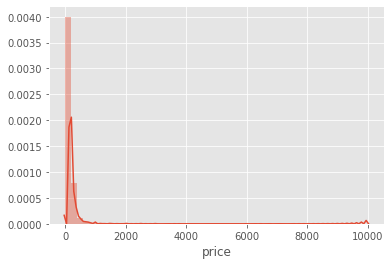

In [184]:
sns.distplot(df['price'])

We can notice that price distribution is far from Gaussian distribution. 
There are some outliers in the analyzed set. So we can try to use logarythmic transformation to change the distribution and in next step get rid off outliers.

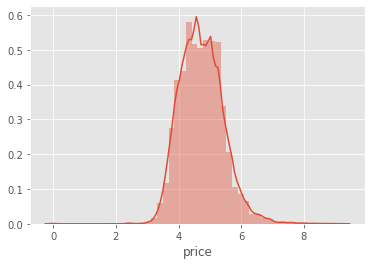

In [185]:
sns.distplot(np.log1p(df['price']))

After this transformation price has distribution similiar to Gaussian. We will also remove outliers by choosing only values between 2.5 and 8 due to analysis of chart above. 

In [186]:
df = df[np.log1p(df['price'])<8]
df = df[np.log1p(df['price'])>2.5]
df.price.describe()

count   48807.00
mean      146.97
std       151.04
min        12.00
25%        69.00
50%       105.00
75%       175.00
max      2900.00
Name: price, dtype: float64

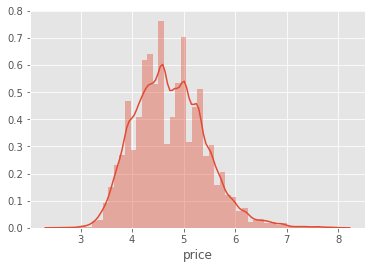

In [187]:
df['price'] = np.log1p(df['price'])
sns.distplot(df['price'])

### 5. Price prediction

Let's start with splitting our dataset into train and test part.

In [188]:
X = df.drop(['price'], axis=1)
y = df.price

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

Now let's try to predict price using some basic model. Our base model will work as below:
- choose listings with the same room_type,
- find couple listings from direct vicinity (smallest distance) of predicted apartment,
- calculate average price of choosen listings.

We will start with defining function which calculate average price from surrounding bookings.

In [190]:
def kneighbours_average(k, lat, lon, base_lat, base_lon, average, room_type):
    df_coords = pd.DataFrame({'latitude':lat[X_train.room_type==room_type].values, 'longitude':lon[X_train.room_type==room_type].values})
    df_base_coords = pd.DataFrame({'latitude':[base_lat], 'longitude':[base_lon]})
    df_dist = pd.DataFrame(distance.cdist(df_coords, df_base_coords, 'euclidean'), columns=['distance']).sort_values(by=['distance'])[1:k+1]
    result = df_dist.merge(average, left_index=True, right_index=True).iloc[:,-1].mean()
    return result


Now we have to calculate predicted value (average) for all observations from test set.

In [191]:
list_average = []
for i in list(X_test.reset_index().index):
    list_average.append(kneighbours_average(5, X_train.latitude, X_train.longitude, X_test.latitude.iloc[i], X_test.longitude.iloc[i], y_train, X_test.room_type.iloc[i]))

In [192]:
y_pred_average = np.array(list_average) #changing list to array

We are gonna valuate our prediction models by metrics such as:
   - MAE - mean absolute error
   - MSE - mean squared error
   - RMSE - mean squared error
   - R2 - r2 score

In [193]:
def scores(test, pred): 
    mae = metrics.mean_absolute_error(test, pred)
    mse = metrics.mean_squared_error(test, pred)
    rmse = np.sqrt(metrics.mean_squared_error(test, pred))
    r2 = metrics.r2_score(test, pred)
    print('MAE (Mean Absolute Error): %s' %mae)
    print('MSE (Mean Squared Error): %s' %mse)
    print('RMSE (Root mean squared error): %s' %rmse)
    print('R2 score: %s' %r2)
    plt.figure(figsize=(8,8))
    plt.scatter(pred, test, alpha = 0.5, s=10)
    plt.plot((2,8), (2,8))
    plt.title('Evaluated predictions', fontsize=15)
    plt.xlabel('Predictions')
    plt.ylabel('Test')

MAE (Mean Absolute Error): 0.593715210787385
MSE (Mean Squared Error): 0.5564908812692934
RMSE (Root mean squared error): 0.7459831641996308
R2 score: -0.20016000936873368


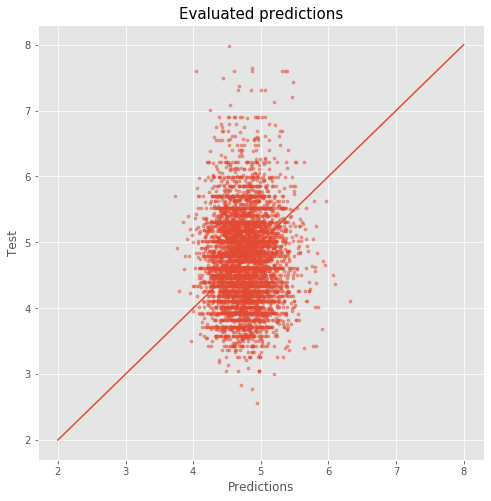

In [194]:
scores(y_test, y_pred_average)

In [195]:
#Let's save results to a list.
Base_model_score=[metrics.mean_absolute_error(y_test, y_pred_average),
           metrics.mean_squared_error(y_test, y_pred_average),
           np.sqrt(metrics.mean_squared_error(y_test, y_pred_average)),
           metrics.r2_score(y_test, y_pred_average)]

As we can see, model based on average prices of the nearest locations is not very good. In next steps we will compare it to other models.

To use our data in models mased on all features we have to change all categorical data to numerical. We'll use one hot endcoding by using pandas function (get_dummies) which changes all categorical features by creating new column for every value.

In [196]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train_original = X_train.copy()
X_test_original = X_test.copy()

Next step is to scale our data so different value ranges won't affect our model. 

In [197]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

At first we will try to run couple regression models without any parameter tuning.

In [198]:
r2_list = []
rmse_list = []
pd.options.display.float_format = '{:.2f}'.format
for model in [LinearRegression(), Ridge(), RandomForestRegressor(), KNeighborsRegressor(), BayesianRidge(), DecisionTreeRegressor(), SVR()]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = round(metrics.r2_score(y_test, y_pred),3)
    rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3)
    r2_list.append(r2)
    rmse_list.append(rmse)

summary = pd.DataFrame({'model': ['LinearRegression', 'Ridge', 'RandomForestRegressor', 'KNeighborsRegressor', 'BayesianRidge', 'DecisionTreeRegressor', 'SVR'],
                        'R2_score': r2_list,
                        'RMSE': rmse_list})

C:\Programy\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [199]:
summary.sort_values(by=['R2_score'], ascending=False)

,model,R2_score,RMSE
6,SVR,0.59,0.43
2,RandomForestRegressor,0.57,0.44
3,KNeighborsRegressor,0.56,0.45
1,Ridge,0.52,0.47
4,BayesianRidge,0.52,0.47
5,DecisionTreeRegressor,0.24,0.59
0,LinearRegression,-1793934695093215952896.00,28841162736.50


As we can see, only Linear Regression didn't manage to predict price. Moreover, most of abovementioned models are better than our base model based on avarege prices. 
Now lets try to improve 3 models which got best R2 score without parameter tuning.

### RandomForestRegressor

In [200]:
RFR_model = RandomForestRegressor()
RFR_model.fit(X_train, y_train)
y_pred_RFR = RFR_model.predict(X_test)

C:\Programy\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MAE (Mean Absolute Error): 0.32203009033180097
MSE (Mean Squared Error): 0.19836136030316234
RMSE (Root mean squared error): 0.4453777725742073
R2 score: 0.572202564223806


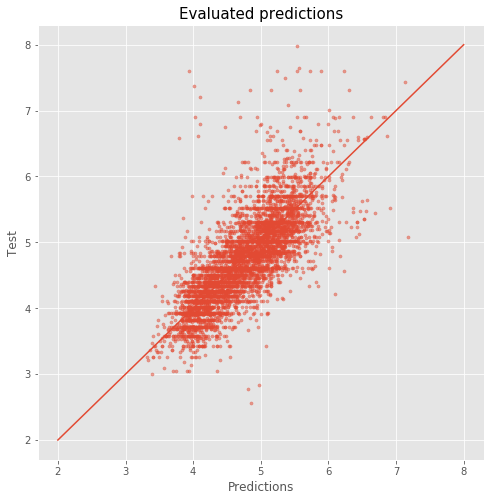

In [201]:
scores(y_test, y_pred_RFR)
RFR_score=[metrics.mean_absolute_error(y_test, y_pred_RFR),
           metrics.mean_squared_error(y_test, y_pred_RFR),
           np.sqrt(metrics.mean_squared_error(y_test, y_pred_RFR)),
           metrics.r2_score(y_test, y_pred_RFR)]

Let's try to improve scores by searching for optimal parameters.

In [202]:
params_RFR = {'max_depth': [10, 50, 100], 'n_estimators': [10, 50, 100, 200]}
gs_RFR = GridSearchCV(estimator=RFR_model, param_grid=params_RFR, cv=5, n_jobs=-1)
gs_RFR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100],
         

In [203]:
gs_RFR.best_params_

{'max_depth': 100, 'n_estimators': 200}

In [204]:
y_pred_RFR_gs = gs_RFR.best_estimator_.predict(X_test)

MAE (Mean Absolute Error): 0.30632380864772263
MSE (Mean Squared Error): 0.18043610327897314
RMSE (Root mean squared error): 0.42477771043096546
R2 score: 0.6108611970283881


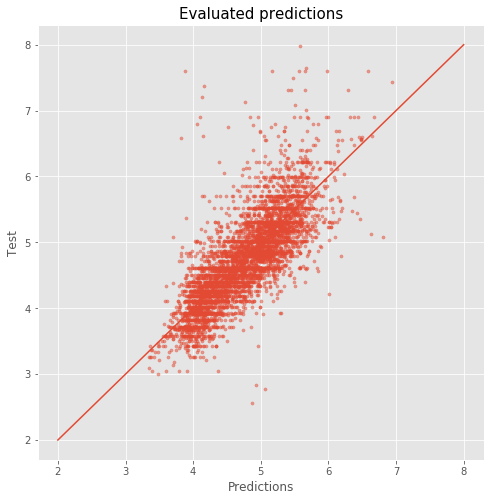

In [205]:
scores(y_test, y_pred_RFR_gs)
RFR_gs_score=[metrics.mean_absolute_error(y_test, y_pred_RFR_gs),
           metrics.mean_squared_error(y_test, y_pred_RFR_gs),
           np.sqrt(metrics.mean_squared_error(y_test, y_pred_RFR_gs)),
           metrics.r2_score(y_test, y_pred_RFR_gs)]

In [206]:
RFR_summary = pd.DataFrame([RFR_score, RFR_gs_score], 
                             index=['RFR','RFR_gs'], 
                             columns = ['mae', 'mse', 'rmse', 'r2'])
RFR_summary.sort_values(by=['r2'] ,ascending=False)

,mae,mse,rmse,r2
RFR_gs,0.31,0.18,0.42,0.61
RFR,0.32,0.20,0.45,0.57


We manage to improve R2 score from 0.55 to 0.59 

Let's try to intepret our model. We will use eli5.show_weights function to see classifier weights.

In [207]:
RFR_best_model = RandomForestRegressor(max_depth = 100, n_estimators = 200)
RFR_best_model.fit(X_train, y_train)
eli5.show_weights(RFR_best_model, feature_names=list(X_train_original.columns))

Weight,Feature
0.3920 ± 0.0075,room_type_Entire home/apt
0.1553 ± 0.0275,longitude
0.1411 ± 0.0127,latitude
0.0720 ± 0.0047,availability_365
0.0499 ± 0.0047,minimum_nights
0.0476 ± 0.0057,exposure_period
0.0395 ± 0.0043,reviews_per_month
0.0339 ± 0.0045,number_of_reviews
0.0295 ± 0.0047,calculated_host_listings_count
0.0282 ± 0.0257,neighbourhood_group_Manhattan


The model used the most weight for columns room_type_Entire home/apt, longitude and latitude which shows that location and room type have the biggest influence to the price. Surprisingly, number of reviews is in the middle of above table and looks like it is not bery significant in price prediction.

### KNeighborsRegressor

In [208]:
KNR_model = KNeighborsRegressor()
KNR_model.fit(X_train, y_train)
y_pred_KNR = KNR_model.predict(X_test)

MAE (Mean Absolute Error): 0.3254591401398764
MSE (Mean Squared Error): 0.20326946039210228
RMSE (Root mean squared error): 0.4508541453642212
R2 score: 0.5616174753265913


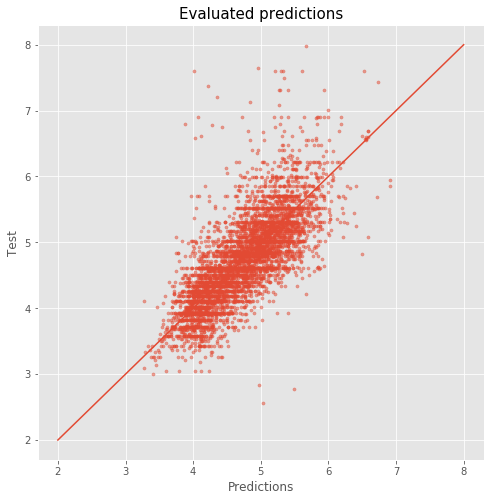

In [209]:
scores(y_test, y_pred_KNR)
KNR_score=[metrics.mean_absolute_error(y_test, y_pred_KNR),
           metrics.mean_squared_error(y_test, y_pred_KNR),
           np.sqrt(metrics.mean_squared_error(y_test, y_pred_KNR)),
           metrics.r2_score(y_test, y_pred_KNR)]

In [210]:
params_KNR = {'n_neighbors': [3, 5, 10, 20], 'weights': ['uniform', 'distance'], 'metric' : ['euclidean', 'manhattan']}
gs_KNR = GridSearchCV(estimator=KNR_model, param_grid=params_KNR, cv=5, n_jobs=-1)
gs_KNR.fit(X_train, y_train)
gs_KNR.best_params_

{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}

In [211]:
y_pred_KNR_gs = gs_KNR.best_estimator_.predict(X_test)

MAE (Mean Absolute Error): 0.30746314037591205
MSE (Mean Squared Error): 0.18294788540744347
RMSE (Root mean squared error): 0.42772407625412373
R2 score: 0.6054441442710072


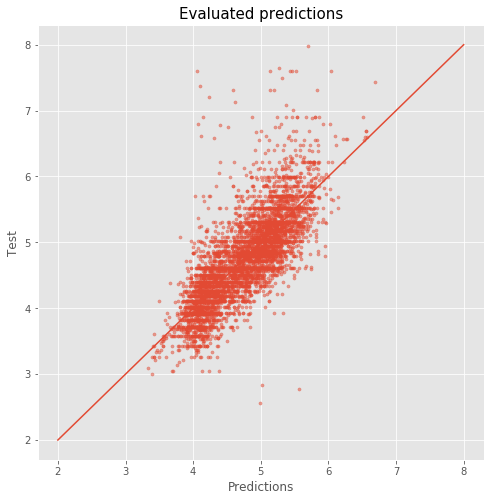

In [212]:
scores(y_test, y_pred_KNR_gs)
KNR_gs_score=[metrics.mean_absolute_error(y_test, y_pred_KNR_gs),
           metrics.mean_squared_error(y_test, y_pred_KNR_gs),
           np.sqrt(metrics.mean_squared_error(y_test, y_pred_KNR_gs)),
           metrics.r2_score(y_test, y_pred_KNR_gs)]

In [213]:
KNR_summary = pd.DataFrame([KNR_score, KNR_gs_score], 
                             index=['KNR', 'KNR_gs'], 
                             columns = ['mae', 'mse', 'rmse', 'r2'])
KNR_summary.sort_values(by=['r2'] ,ascending=False)

,mae,mse,rmse,r2
KNR_gs,0.31,0.18,0.43,0.61
KNR,0.33,0.20,0.45,0.56


We manage to improve R2 score from 0.56 to 0.60 

### SVR

In [214]:
SVR_model = SVR()
SVR_model.fit(X_train, y_train)
y_pred_SVR = SVR_model.predict(X_test)

MAE (Mean Absolute Error): 0.3094055662409337
MSE (Mean Squared Error): 0.18872711583251256
RMSE (Root mean squared error): 0.4344273424089609
R2 score: 0.5929803259506157


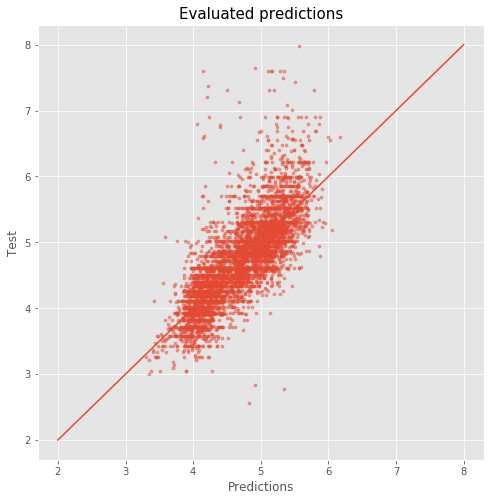

In [215]:
scores(y_test, y_pred_SVR)
SVR_score=[metrics.mean_absolute_error(y_test, y_pred_SVR),
           metrics.mean_squared_error(y_test, y_pred_SVR),
           np.sqrt(metrics.mean_squared_error(y_test, y_pred_SVR)),
           metrics.r2_score(y_test, y_pred_SVR)]

In [216]:
params_SVR = {'kernel': ['rbf', 'linear', 'poly']}
gs_SVR = GridSearchCV(estimator=SVR_model, param_grid=params_SVR, cv=5, n_jobs=-1)
gs_SVR.fit(X_train, y_train)
gs_SVR.best_params_

{'kernel': 'rbf'}

In [217]:
params_SVR = {'C': [0.01, 0.1, 1, 10, 100]}
gs_SVR = GridSearchCV(estimator=SVR_model, param_grid=params_SVR, cv=5, n_jobs=-1)
gs_SVR.fit(X_test, y_test)
gs_SVR.best_params_

{'C': 1}

Default parameters (kernel 'rbf', Regularization C = 1) proved to be the best so we take default result as the best.

### 6. Summary

In [222]:
Score_summary = pd.DataFrame([RFR_score, RFR_gs_score, KNR_score, KNR_gs_score, SVR_score, Base_model_score], 
                             index=['RandomForestRegressor','RandomForestRegressor_tuned', 'KNeighborsRegressor', 'KNeighborsRegressor_tuned', 'SupportVectorRegression', 'BaseModelAverage'], 
                             columns = ['MAE', 'MSE', 'RMSE', 'R2score'])
Score_summary.sort_values(by=['R2score'] ,ascending=False)

,MAE,MSE,RMSE,R2score
RandomForestRegressor_tuned,0.31,0.18,0.42,0.61
KNeighborsRegressor_tuned,0.31,0.18,0.43,0.61
SupportVectorRegression,0.31,0.19,0.43,0.59
RandomForestRegressor,0.32,0.20,0.45,0.57
KNeighborsRegressor,0.33,0.20,0.45,0.56
BaseModelAverage,0.59,0.56,0.75,-0.20


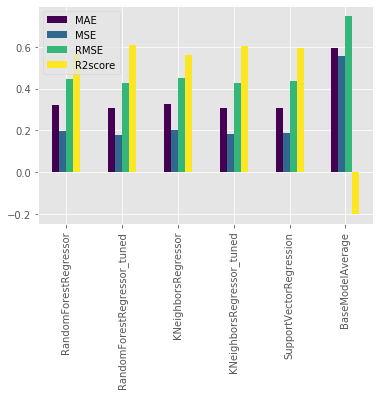

In [223]:
Score_summary.plot(kind='bar', cmap = 'viridis')

The best model for the R2_score and root mean square error is KNeighborsRegressor with tuned parameter. Using gridsearch  optimal parameters was found ('metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'). 

Presented model is not perfect and was made for educational purposes. Due to time and hardware limitations, the analyzes performed have been simplified. Better results can certainly be obtained by further tuning of parameters and using different regression models. However all of the test models were better than simple base model which predicted prices based on the average price of nearest listings.

Moreover analyzed dataset is basic and could contain more specific data. There is no specific information about reviews, only the total number of them. Therefore, we cannot assess whether the reviews are positive or negative. Detailed scoring data would definitelly increase model performance. We also didn't know anything about number of bookings and exact location. 

However, according to the best model weights (RandomForestRegressor_tuned), we can conclude that room type, longitude and latitude have the biggest influence to predicted price. It seems to be correct that location have one of the bigest impact to apartment price.

To improve our results, we could conduct more spatial analysis for example to evaluate location more detailed, like distance from metro station and other services availability. 

License: CC0 1.0 Universal (CC0 1.0) Public Domain Dedication